In [1]:
import time

import cv2
import numpy as np
import matplotlib.pyplot as plt

from RANSAC import get_inliers, get_best_dist
from ImgCropper import ImgCropper

(1648, 1539, 3)
(1648, 1539)


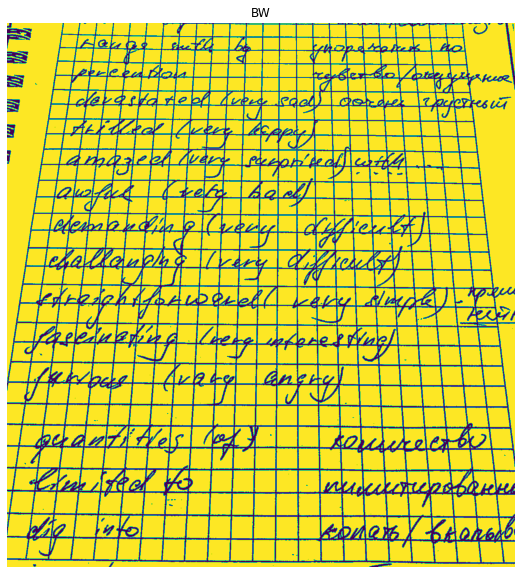

In [13]:
imagergb = cv2.imread('images/nb4.jpg')
print(imagergb.shape)
img = cv2.cvtColor(imagergb,cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

## do morph-dilate-op
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10,10))
dilated = cv2.morphologyEx(gray, cv2.MORPH_DILATE, kernel)
## do medianBlur
median = cv2.medianBlur(dilated, 5)
diff2 = 255 - cv2.subtract(median, gray)
## do normalization
normed = cv2.normalize(diff2,None, 10, 255, cv2.NORM_MINMAX )

bw = cv2.threshold(normed, 210, 255, cv2.THRESH_BINARY)[1]
plt.figure(figsize=(10,10))
plt.clf()
plt.axis("off")
plt.title("BW")
plt.imshow(bw)

edges = cv2.Canny(bw, 200, 120, apertureSize=3, L2gradient=True)
print(edges.shape)

In [14]:
1539/4.5

342.0

In [15]:
lines = cv2.HoughLines(edges, 1, np.pi/360, 342,)
lines_points = np.empty((len(lines), 4), dtype=int)
lines_coefs = np.empty((len(lines), 3))

for i, line in enumerate(lines):
    for rho, theta in line:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1648*(-b))
        y1 = int(y0 + 1648*(a))
        x2 = int(x0 - 1648*(-b))
        y2 = int(y0 - 1648*(a))
        lines_points[i] = (x1, y1, x2, y2)
        lines_coefs[i] = np.cross((x1, y1, 1), (x2, y2, 1))

In [16]:
%%time
print(f"found lines: {len(lines_coefs)}")  
line_group1, mask, v_point1 = get_inliers(lines_coefs, iters=2000, epsilon=0.005)
print(f"lines in group 1: {len(line_group1)}")

found lines: 194


/Users/masha/Documents/GitHub/masters-degree-project/RANSAC.py:33: RuntimeWarning: invalid value encountered in true_divide
  cross_points_norm = cross_points / norm(cross_points, axis=1)[:,None]
/Users/masha/Documents/GitHub/masters-degree-project/RANSAC.py:35: RuntimeWarning: invalid value encountered in arccos
  mask_temp = abs(arccos(inner(vanishing_temp_norm, cross_points_norm))) < epsilon


lines in group 1: 149
CPU times: user 633 ms, sys: 10.3 ms, total: 644 ms
Wall time: 774 ms


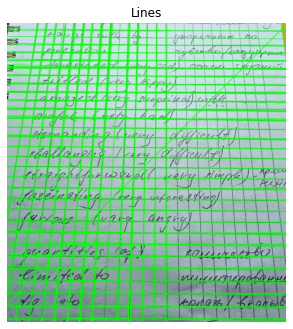

In [17]:
img_copy = img.copy()
lines_points1 = lines_points[mask]
v = v_point1/v_point1[2]
for i, (x1, y1, x2, y2) in enumerate(lines_points1):
    if abs(v[0]/v[1]) < 1:
        cv2.line(img_copy, (x1, y1), (x2, y2), (255,0,0),2)
    else:
        cv2.line(img_copy, (x1, y1), (x2, y2), (0,255, 0),2)
    
plt.figure(figsize=(5,10))
plt.clf()
plt.axis("off")
plt.title("Lines")
plt.imshow(img_copy)  

In [18]:
lines_points = lines_points[~mask]
line_group2, mask, v_point2 = get_inliers(lines_coefs[~mask], iters=2000, epsilon=0.005)
print(f"lines in group 2: {len(line_group2)}")

lines in group 2: 43


-113.62068965517241 -0.008500303582270795


(1648, 1539, 3)

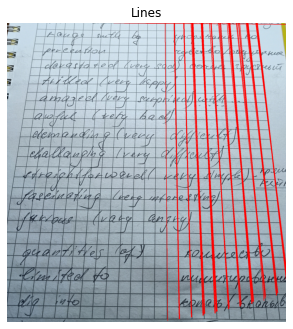

In [19]:
img_copy = img.copy()
lines_points2 = lines_points[mask]
v = v_point2/v_point2[2]
for i, (x1, y1, x2, y2) in enumerate(lines_points2):
    if abs(v[0]/v[1]) >1:
        cv2.line(img_copy, (x1, y1), (x2, y2), (255,0,0),2)
    else:
        cv2.line(img_copy, (x1, y1), (x2, y2), (0,255, 0),2)
        
print(np.min(line_group2[:, 0]/line_group2[:, 1]), np.max(line_group2[:, 0]/line_group2[:, 1]))


    
plt.figure(figsize=(5,10))
plt.clf()
plt.axis("off")
plt.title("Lines")
plt.imshow(img_copy) 
img_copy.shape

In [20]:
v = v_point1
abs(v[0]/v[1])

901.986419459652

In [21]:
v = v_point2/v_point2[2]

abs(v[0]/v[1])

1181.102311030212

line_group2 \
0 (x-intersept) min -8.71188659e-07 (0), max -5.64787095e-08 (35) \
1 (y-intersept) min 0.00045177 (35) , max 0.00696864 (0)

line_group1\
0 (x-intersept) min 0.00063412 (29), max 0.00617284(41)\
1 (y-intersept) min 0 (0), max 0 (0)




line_group2 \
0 (x-intersept) min -8.71188659e-07 (0), max -5.64787095e-08 (35)\
line_group1\
 + 0 (x-intersept) min 0.00063412 (29), max 0.00617284(41)

line_group2 \
 + 1 (y-intersept) min 0.00045177 (35) , max 0.00696864 (0)
line_group1\
1 (y-intersept) min 0 (0), max 0 (0)

In [119]:
# sclopes1 = -line_group2[:, 0]/line_group2[:, 1]
# print(sclopes1)
# # line_group1_.sort()
print(' ', 'idx', 'rule','correct intercept', 'incorrect intercept', sep='\t')
print("top", np.argmin(-(line_group1[:, 2]/line_group1[:, 1])),'min', np.min(-(line_group1[:, 2]/line_group1[:, 1])), np.min(-(line_group2[:, 2]/line_group2[:, 1])), sep='\t')
print("left",np.argmin(-(line_group2[:, 2]/line_group2[:, 0])),'min', np.min(-(line_group2[:, 2]/line_group2[:, 0])), np.min(-(line_group1[:, 2]/line_group1[:, 0])), sep='\t')
print("bottom", np.argmax(-(line_group1[:, 2]/line_group1[:, 1])),'max', np.max(-(line_group1[:, 2]/line_group1[:, 1])), np.max(-(line_group2[:, 2]/line_group2[:, 1])), sep='\t')
print("right",np.argmax(-(line_group2[:, 2]/line_group2[:, 0])),'max', np.max(-(line_group2[:, 2]/line_group2[:, 0])), np.max(-(line_group1[:, 2]/line_group1[:, 0])), sep='\t')



# # np.max(A[~np.logical_or(A[:,1]<=xmin, A[:,0]>=xmax),2]))
l1 = line_group2[35] #argmin 895.740  -7572.23901
l2 = line_group1[50]  #argmin -11.21   3880.71
l3 = line_group2[48] #argmax 4127.913 79.855
l4 = line_group1[51] #argmax 2029.5   19423.28


corner_points = np.cross([l1, l2, l3, l4], [l2, l3, l4, l1])
corners = (corner_points / corner_points[:, 2][:, None])[:, :2]
corners

 	idx	rule	correct intercept	incorrect intercept
top	34	min	112.5086271567892	-53153.79136690647
left	5	min	218.21105781368342	-13058368.0
bottom	28	max	1632.5000625078135	2069.577181208054
right	18	max	1381.2082546873035	-13041.217391304348


IndexError: index 35 is out of bounds for axis 0 with size 22

In [242]:
(line_group1[:, 0]/line_group1[:, 1] > 1) | (line_group1[:, 0]/line_group1[:, 1] < -1)



array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [120]:
def _find_corner_points(line_group2, line_group1):
#     vertical = lines[(lines[:, 0]/lines[:, 1] > 1) | (lines[:, 0]/lines[:, 1] < -1)]
#     horizontal = lines[(lines[:, 0]/lines[:, 1] > -1) & (lines[:, 0]/lines[:, 1] < 1)]
    
    l1 = line_group2[(-line_group2[:, 2]/line_group2[:, 1]).argmin()] #y-intercept - top
    l2 = line_group1[(-line_group1[:, 2]/line_group1[:, 0]).argmin()] #x-intercept - left
    l3 = line_group2[(-line_group2[:, 2]/line_group2[:, 1]).argmax()] #x-intercept - bottom
    l4 = line_group1[(-line_group1[:, 2]/line_group1[:, 0]).argmax()] #y-intercept - right
    print(l1, l2, l3, l4)
    corner_points = np.cross([l1, l2, l3, l4], [l2, l3, l4, l1])
    return (corner_points / corner_points[:, 2][:, None])[:, :2]

# selected_lines = np.concatenate((line_group1, line_group2), axis=0)
corners = _find_corner_points(line_group1, line_group2)
# corners = np.array(corners, dtype=np.int32)
corners

[-6.90000e+01  7.99800e+03 -8.99844e+05] [ 7.922000e+03  1.112000e+03 -1.728668e+06] [-1.0000000e+00  7.9990000e+03 -1.3058368e+07] [-7.9470000e+03  9.0500000e+02  1.0976462e+07]


array([[ 202.17355153,  114.25281008],
       [ -10.94048834, 1632.49869478],
       [1567.13877706, 1632.69597934],
       [1395.39158609,  124.54688915]])

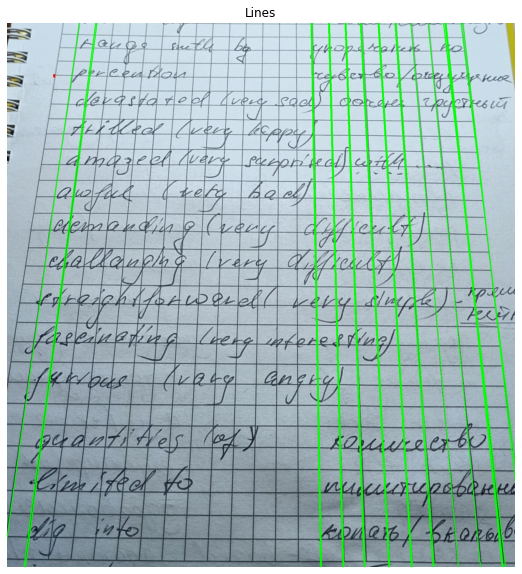

In [121]:
img_copy[155:165, 140:146]= [255, 0, 0]
plt.figure(figsize=(10,10))
plt.clf()
plt.axis("off")
plt.title("Lines")
plt.imshow(img_copy)  

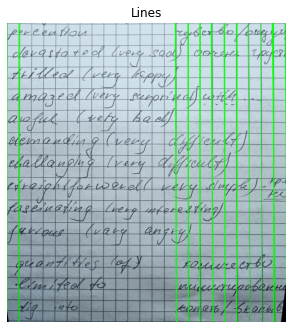

In [122]:
cropped_shape = img_copy.shape[1], img_copy.shape[0]
srcpts = np.float32([corners])
destpts = np.float32([[0, 0], [0, cropped_shape[1]], cropped_shape, [cropped_shape[0], 0]])
resmatrix = cv2.getPerspectiveTransform(srcpts, destpts)
img_copy_new = cv2.warpPerspective(img_copy, resmatrix, cropped_shape) 
plt.figure(figsize=(5,10))
plt.clf()
plt.axis("off")
plt.title("Lines")
plt.imshow(img_copy_new)  

In [136]:
cv2.imwrite('./images/test.png', img_copy_new)

True